In [1]:
import sys
# Hay que ejecutar esta línea antes de importar el módulo.
sys.path.append("C:/Users/Vicen/PycharmProjects/tgpy")
# Ahora se puede importar el módulo.
%reload_ext tgpy
import tgpy as tg
import matplotlib.pyplot as plt
import mpl_scatter_density
import utm
import pydeck as pdk
import pandas as pd
import numpy as np
import seaborn as sb
import random
from scipy import signal
from sklearn.metrics import mean_absolute_error

In [2]:
sb.set_context('notebook', font_scale=1.4)
sb.set_style('ticks')
plt.rcParams['figure.figsize'] = (12, 5)



# Funcion de extrarccion de parametros:

In [3]:
    def get_priors_dt(self, npriors: int):
        """
        Save the value of sample in a dict

        :param npriors: an int, the number of groups
        :return: a dict, value of sample for each prior and group
        """
        prior_dict = {}
        for i in range(npriors):
                prior_dict[('prior{}'.format(i), 'Year')] = self._priors_dict['prior{}'.format(i)].p[
                    'Year'].data.clone().detach().cpu().numpy() # se ha adecuar a los como se guardo el dict de los parametros
        return prior_dict

# Entranamiento de un GP: 

In [4]:
Sunspots = pd.read_csv('Sunspots.csv')
Sunspots['year'] = pd.DatetimeIndex(Sunspots['Date']).year
Sunspots_train_anual = Sunspots[['year','Monthly Mean Total Sunspot Number']]
Sunspots_train_anual = Sunspots_train_anual.groupby("year", as_index=False).mean()
Sunspots_train_anual = Sunspots_train_anual.iloc[51:272]
(Sunspots_train_anual).reset_index(inplace=True, drop=True)
S_train = Sunspots_train_anual

In [5]:
S_train['year']

0      1800
1      1801
2      1802
3      1803
4      1804
       ... 
216    2016
217    2017
218    2018
219    2019
220    2020
Name: year, Length: 221, dtype: int32

In [6]:
S_train['year'] = S_train['year']-S_train[
    'year'].min()
S_train

,year,Monthly Mean Total Sunspot Number
0,0,24.125000
1,1,56.650000
2,2,75.050000
3,3,71.750000
4,4,79.108333
...,...,...
216,216,39.825000
217,217,21.816667
218,218,7.008333
219,219,3.583333


In [7]:


t_anual = S_train["year"]-S_train["year"]
y_anual = S_train["Monthly Mean Total Sunspot Number"]
prop = 0.8
obs = int(prop*len(t_anual))
train_index_anual = range(obs)
valid_index_anual = range(obs,len(t_anual))
t_obs_anual = t_anual[train_index_anual]
y_obs_anual = y_anual[train_index_anual]
t_val = t_anual[valid_index_anual]
y_val = y_anual[valid_index_anual]



In [8]:
valid_index_anual


range(176, 221)

In [9]:
S_train['Monthly Mean Total Sunspot Number'].mean()

79.72021116138765

In [10]:
y_obs_anual

0      24.125000
1      56.650000
2      75.050000
3      71.750000
4      79.108333
         ...    
171    94.425000
172    97.691667
173    54.291667
174    49.150000
175    22.408333
Name: Monthly Mean Total Sunspot Number, Length: 176, dtype: float64

In [11]:
print(len(t_anual),len(t_obs_anual))

221 176


In [12]:
def train(tgp, quantiles = 0.9, nsamples = 10, delta = 0.5, npoints = 21):
    tgp.sample_priors()
    tgp.plot_priors(kde=True)
    learning = tg.TgLearning(tgp, lr=0.001, pbatch=0.8, pot=0, cycle=0.1) #rand_pert=0.0
    learning.execute_svgd(100)
    tgp.plot_priors(kde=True)
    return 

## Modelo Kernel SE

In [13]:
def model_se(df, index_obs, dim = 100): 
    inputs = ['year']
    outputs = ["Monthly Mean Total Sunspot Number"]
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)
   
    
    var_se = tg.TgPrior('var', ['Sunspots'], dim=dim, low=0.001, high=2, alpha=4, beta=2)
    ls = tg.TgPrior('ls', ['year'], dim=dim, low=0.01, high=0.05, alpha=2, beta=4) #low = 0.0, high = 2
    noise = tg.TgPrior('noise', ['noise'], dim=dim, low=0.001, high=0.5, alpha=2, beta=4)
    shift = tg.TgPrior('shift', ['Sunspots'], dim=dim, low=-0.01, high=0.01, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Sunspots'], dim=dim, low=0.01, high=1.2, alpha=2, beta=4)
    
    kernel = tg.SE(var_se, ls)
    cov = tg.CovarianceTransport(kernel, noise=tg.WN(noise))
    marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift) )
    positive = tg.MarginalTransport(tg.Relu())
    
    tgp = tg.TGP([cov,marginal,positive], dt=dt)
    tgp.obs(index_obs)
    return tgp

In [14]:
tgp_se = model_se(S_train, train_index_anual)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
tgp_se.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 10
                    , noise=False, plot_samples=True, statistic="Median", Proportion_prior=0.2)

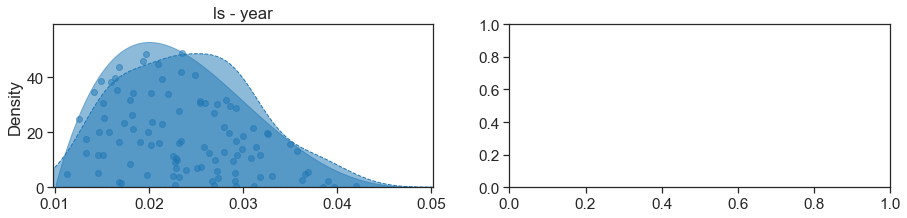

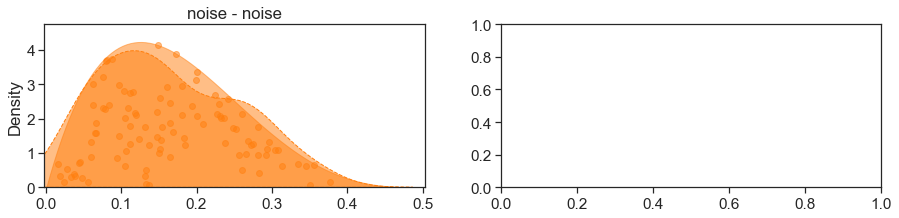

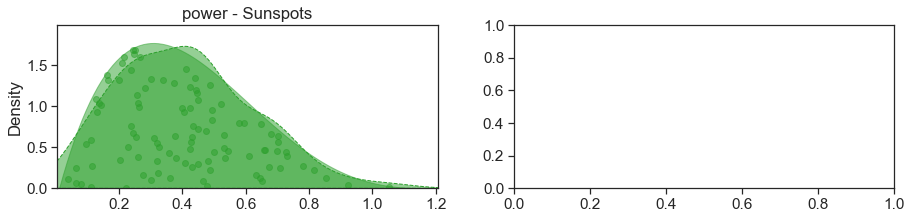

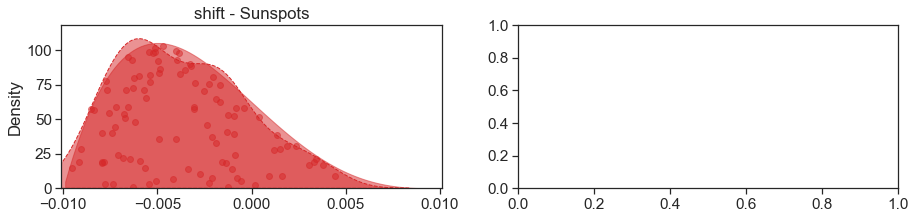

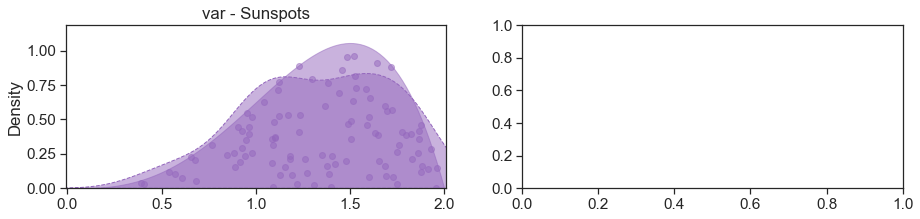

  0%|                                                                                                         …

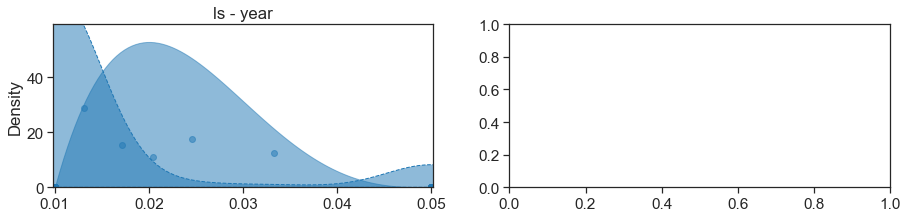

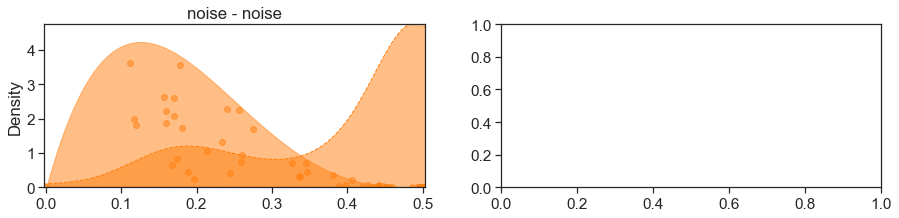

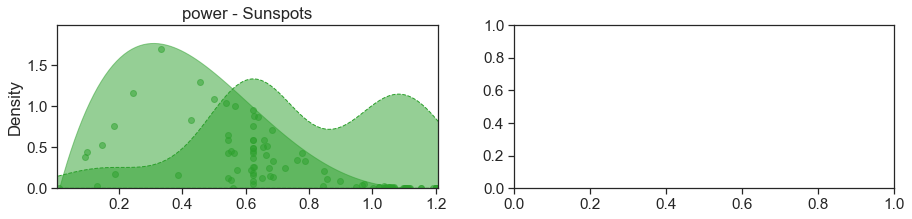

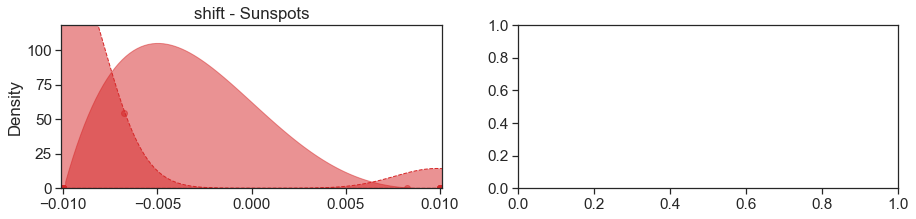

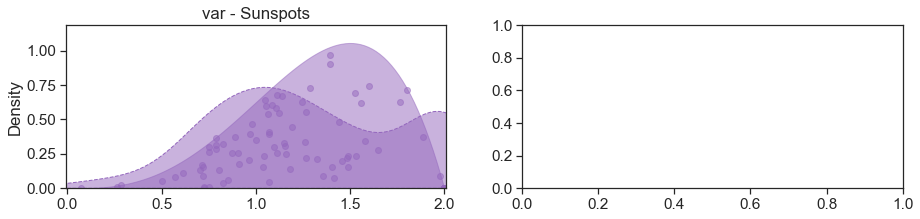

In [17]:
train(tgp_se)

# Modelo entrenado SE

In [31]:
tgp_se.plot_predict('Sunspots Gaussian Process', 'Year', 'Yearly Mean of Total Sunspots Number',
                    nsamples = 10, noise=False, plot_samples=True,
                    ylim_by_CI=True)

NameError: name 'tgp_se' is not defined

## Modelo Kernel SM

In [24]:
def model_sm(df, index_obs, dim = 100): 
    inputs = ['year']
    outputs = ["Monthly Mean Total Sunspot Number"]
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs, device='cpu')
    
    # 
    var_sm_1 = tg.TgPrior('var_sm_1', ['var_sm_1'], dim=dim, low=0.01, high=2, alpha=2, beta=4)
    ls_1 = tg.TgPrior('ls_1', ['relevance_1'], dim=dim, low=0.01, high=0.5, alpha=2, beta=4) #low = 0.0, high = 2
    period_1 = tg.TgPrior('period_1', ['period_1'], dim=dim, low=0.01, high=0.3, alpha=None, beta=3,mode=0.1)#low = 1, high = 5 # debo centrar
    
    
    
    noise = tg.TgPrior('noise', ['noise'], dim=dim, low=0.001, high=0.5, alpha=2, beta=4)
    shift = tg.TgPrior('shift', ['Sunspots'], dim=dim, low=-0.01, high=0.01, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Sunspots'], dim=dim, low=0.01, high=1.2, alpha=2, beta=4)
    kernel_1 = tg.SM(var_sm_1, ls_1, period_1)
    
    #kernel = tg.KernelSum(kernel_1, kernel_2)
    
    cov = tg.CovarianceTransport(kernel_1, noise=tg.WN(noise))
    marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift) )
    positive = tg.MarginalTransport(tg.Relu())
    
    tgp = tg.TGP([cov,marginal,positive], dt=dt)
    
    tgp.obs(index_obs)
    return tgp

In [25]:
tgp_sm = model_sm(S_train, train_index_anual)

In [26]:
tgp_sm.dt.index

RangeIndex(start=0, stop=221, step=1)

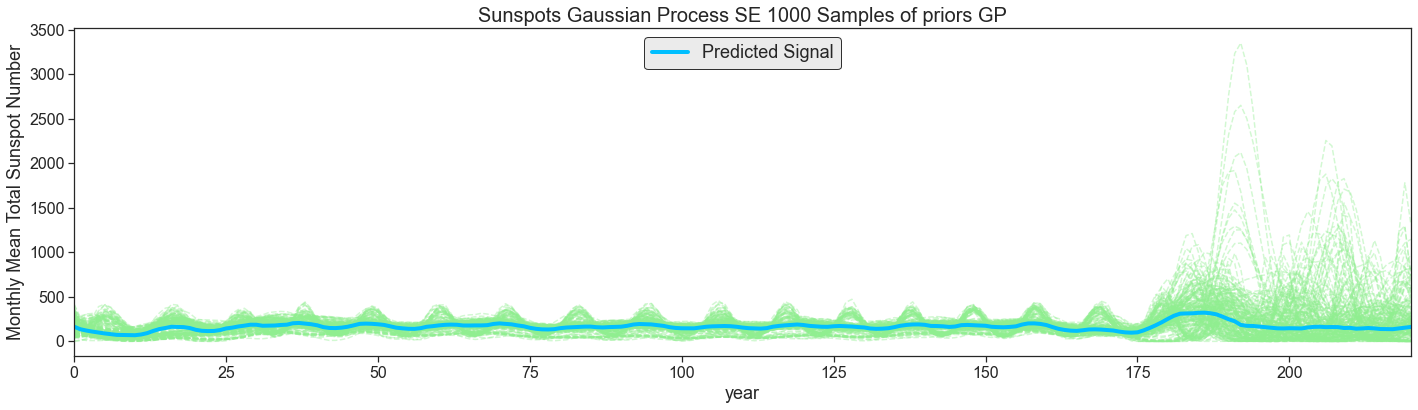

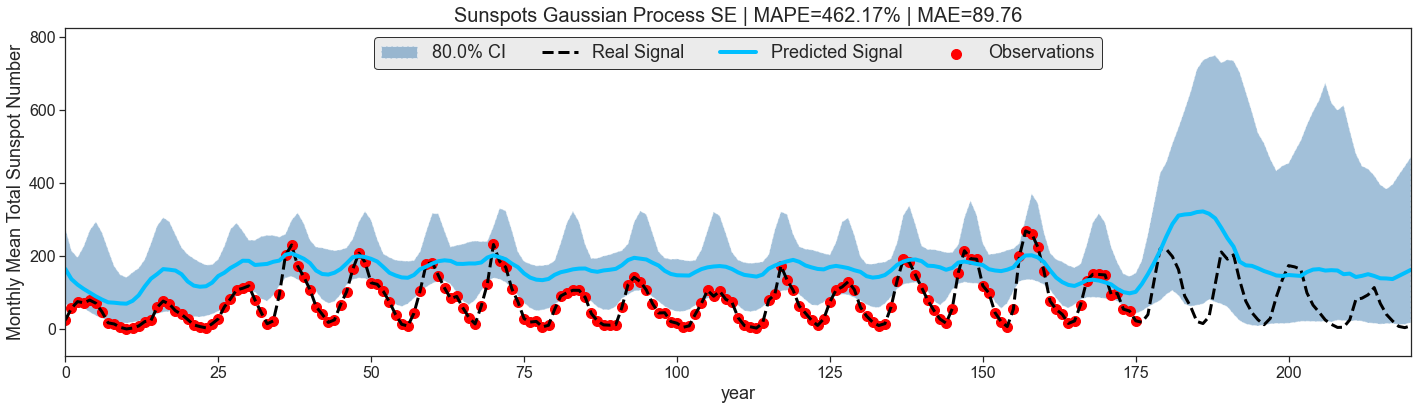

In [27]:
tgp_sm.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 10
                    , noise=False, plot_samples=True, statistic="Median", Proportion_prior=0.2)

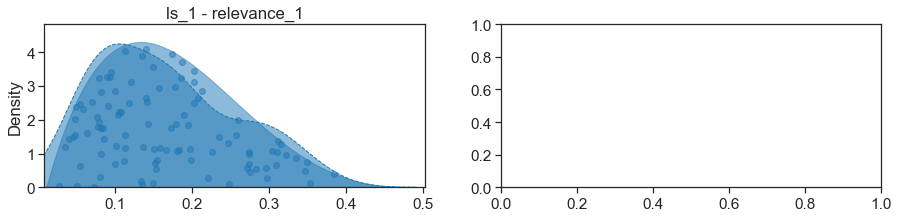

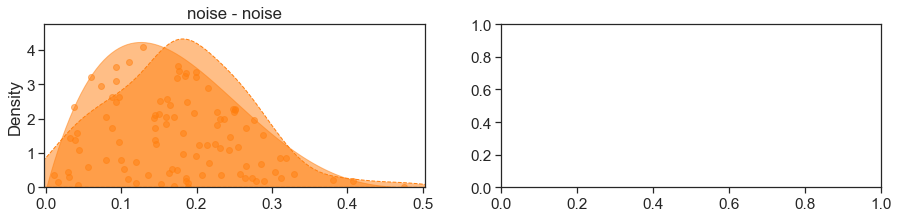

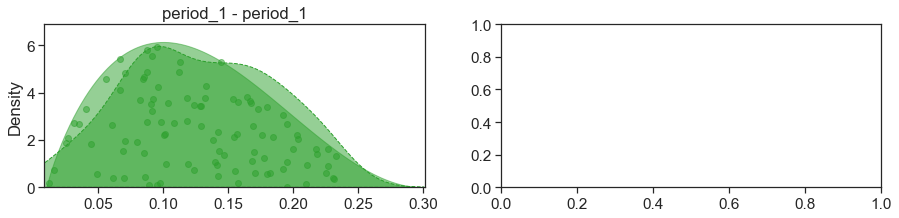

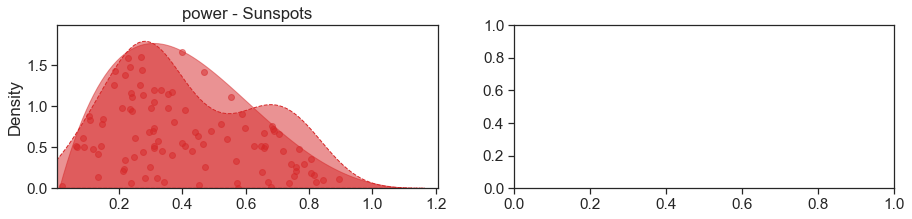

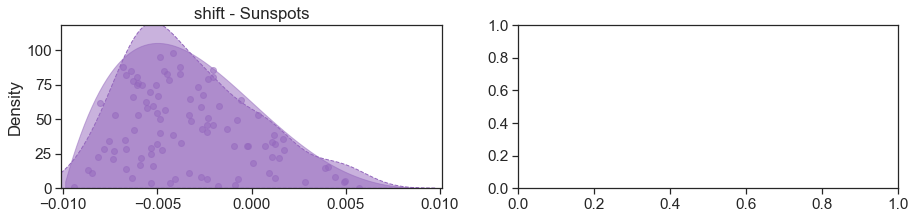

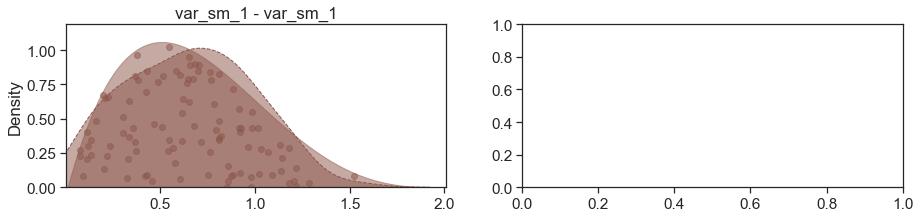

  0%|                                                                                                         …

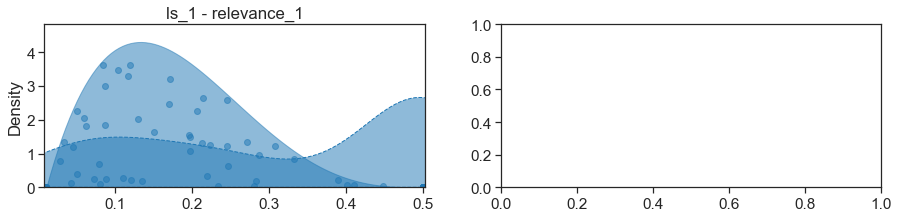

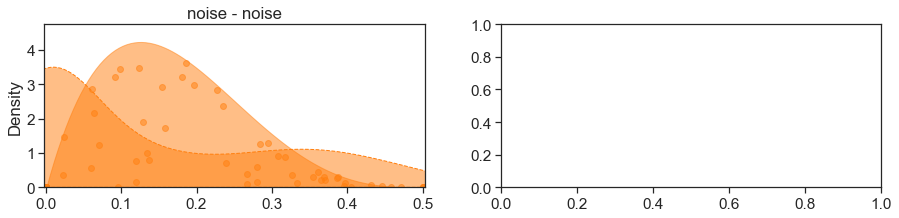

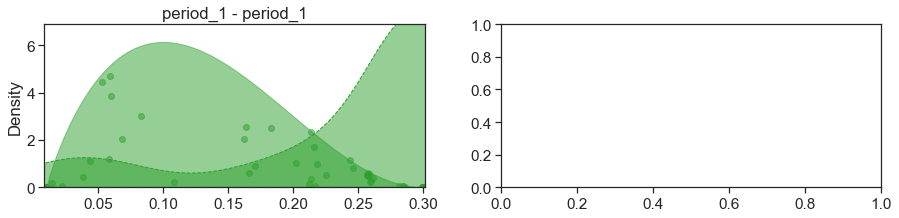

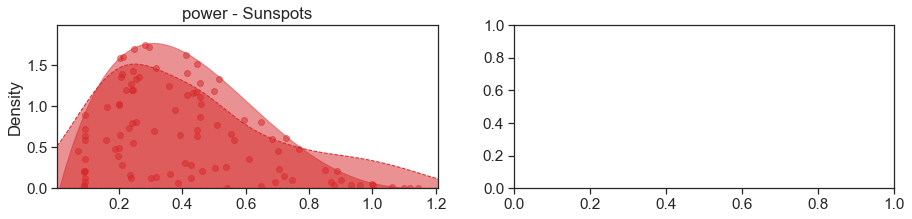

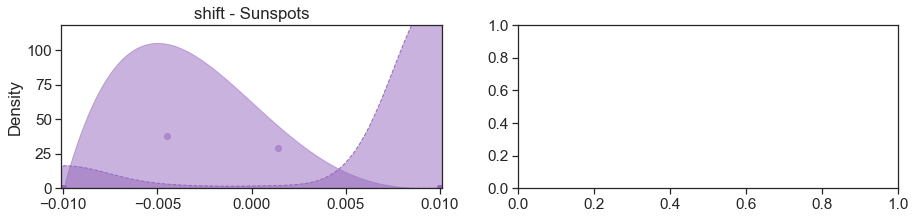

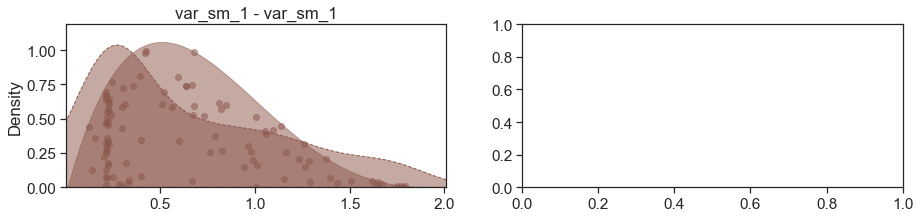

In [28]:
train(tgp_sm)

# Modelo entrenado SM

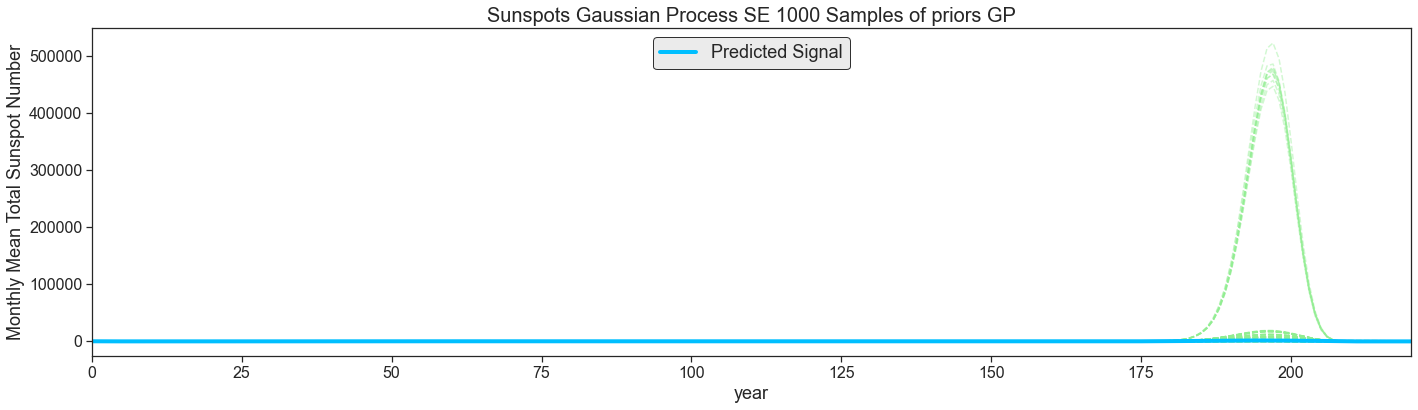

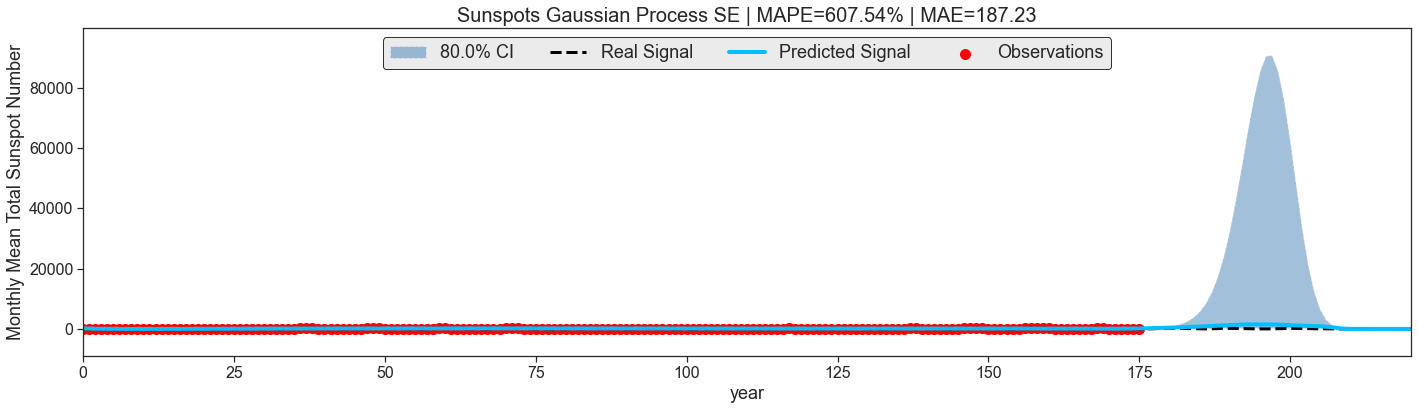

In [30]:
tgp_sm.plot_predict('Sunspots Gaussian Process SE', 'year', "Monthly Mean Total Sunspot Number", nsamples = 10
                    , noise=False, plot_samples=True, statistic="Median", Proportion_prior=0.2)

# Codigo:  SM*SE + SE

In [126]:
def model_sm_2(df, index_obs, dim = 100): 
    inputs = ['year']
    outputs = ["Monthly Mean Total Sunspot Number"]
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs, device='cpu')

    var_se = tg.TgPrior('var_se', ['year'], dim=dim, low=0.01, high=3, alpha=2, beta=4)
    var_sm = tg.TgPrior('var_sin', ['year'], dim=dim, low=0.01, high=2, alpha=2, beta=4)
    var_se_sum = tg.TgPrior('var_se_sum', ['year'], dim=dim, low=0.01, high=3, alpha=2, beta=4)
    
   
    relevance_se = tg.TgPrior('relevance_se', ['year'], dim=dim, low=0.0, high=2, alpha=4, beta=2) #low = 0.0, high = 2
    relevance_sm = tg.TgPrior('relevance_sin', ['year'], dim=dim, low=0.02, high=0.08, alpha=4, beta=2)
    relevance_se_sum = tg.TgPrior('relevance_se_sum', ['year'], dim=dim, low=2, high=3, alpha=4, beta=2)
    
    freedom = tg.TgPrior('freedom', ['year'], dim=dim, low=1, high=0.01, alpha=2, beta=4) #low = 1, high = 5
    period = tg.TgPrior('period', ['year'], dim=dim, low=0.01, high=0.08, alpha=4, beta=2)
    
    

    power = tg.TgPrior('power', ['year'], dim=dim, low=0.01, high=1.2, alpha=2, beta=4)
    
    SE = tg.SE(var_se, relevance_se)
    SE_sum = tg.SE(var_se_sum, relevance_se_sum)
    SM = tg.SM(var_sm, relevance_sm, period)
    kernel_prod  = tg.KernelProd(SM, SE)
    kernel = tg.KernelSum(kernel_prod, SE_sum)
    cov = tg.CovarianceTransport(kernel)
    
    tgp = tg.TGP([cov], dt=dt)
    tgp.obs(index_obs)
    return tgp

In [127]:
tgp_sm_2 = model_sm_2(S_train, train_index_anual)

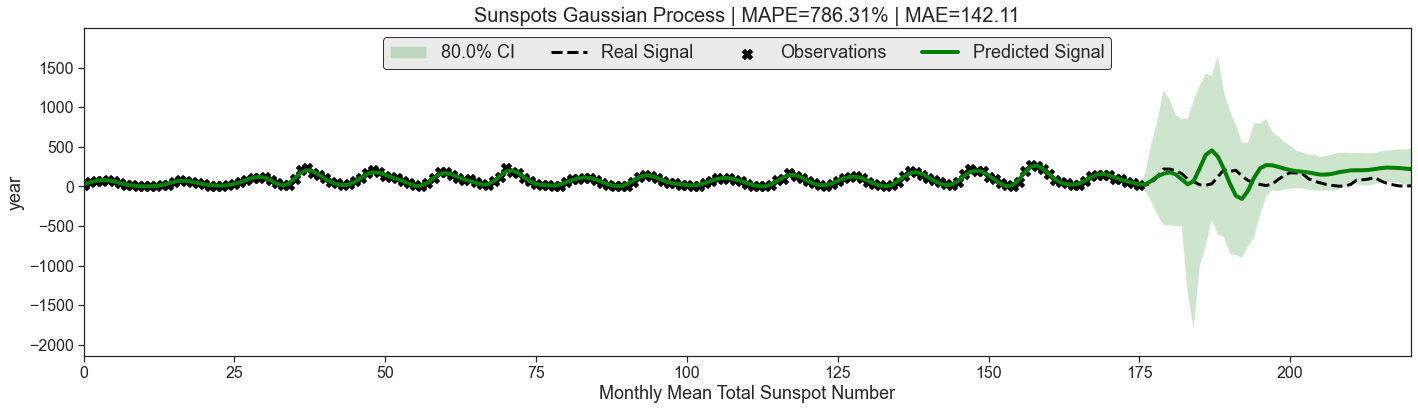

In [128]:
(tgp_sm_2).plot_predict('Sunspots Gaussian Process','Monthly Mean Total Sunspot Number','year', nsamples=10, valid_index=valid_index_anual, plot_samples = False, 
            )

  0%|                                                                                                         …

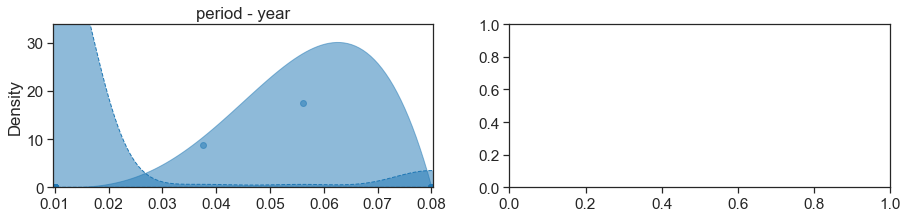

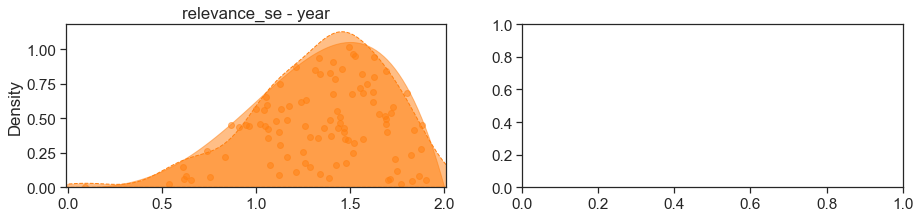

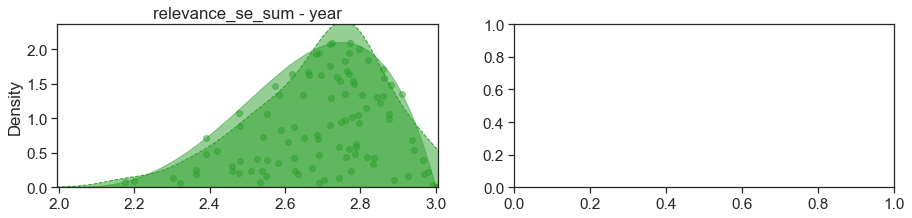

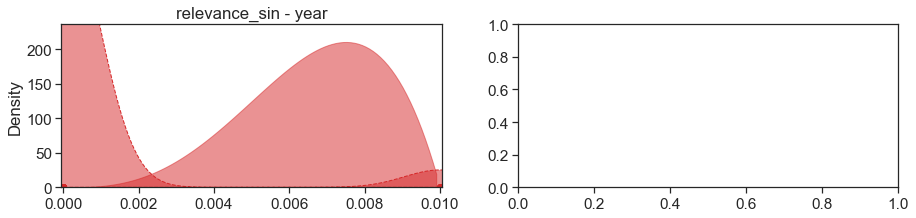

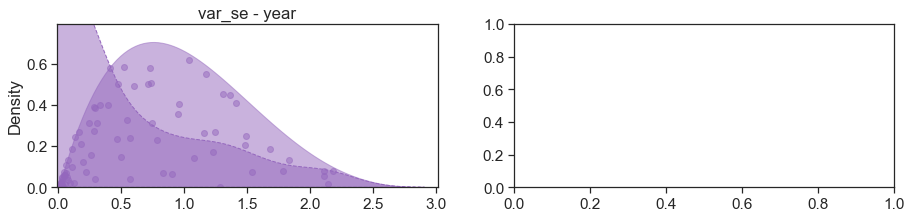

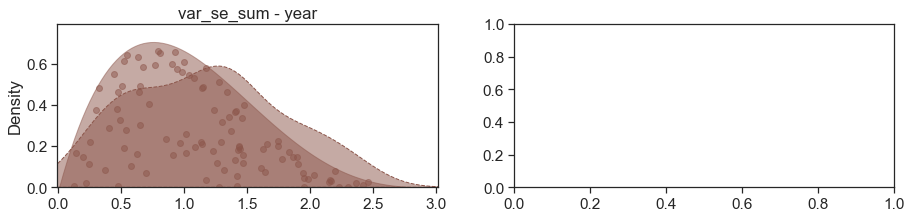

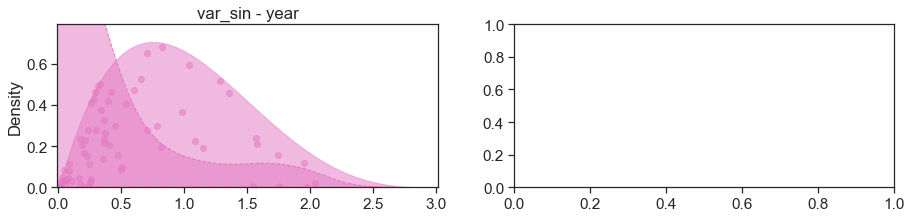

In [118]:
train(tgp_sm_2)

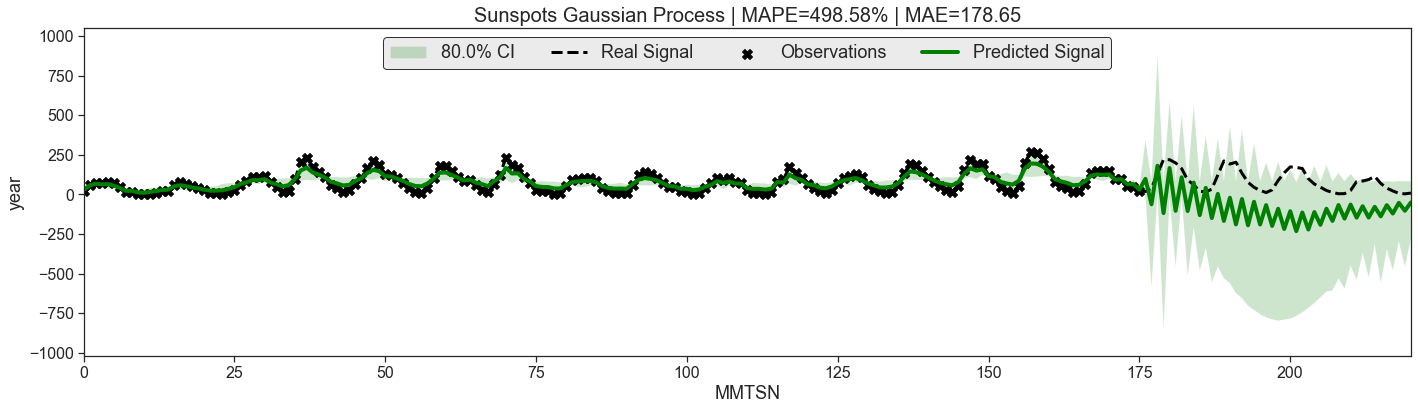

In [114]:
tgp_sm_2.plot_predict('Sunspots Gaussian Process', 'MMTSN', 'year', nsamples=10, valid_index=valid_index_anual)

# SIN*SE + POL 

In [100]:
def model_ssp(df, index_obs, dim = 100): 
    inputs = ['year']
    outputs = ['Monthly Mean Total Sunspot Number']
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs,device='cpu')

    var_sin = tg.TgPrior('var_sin', ['Average'], dim=dim, low=0, high=4, alpha=2, beta=4)
    var_se = tg.TgPrior('var_se', ['Average'], dim=dim, low=0, high=4, alpha=2, beta=4)
    
    relevance_sin = tg.TgPrior('relevance_sin', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2
    relevance_pol = tg.TgPrior('relevance_pol', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2
    relevance_se = tg.TgPrior('relevance_se', ['Average'], dim=dim, low=0.0, high=3, alpha=4, beta=2) #low = 0.0, high = 2

    freedom = tg.TgPrior('freedom', ['Average'], dim=dim, low=1, high=5, alpha=2, beta=4) #low = 1, high = 5
    period = tg.TgPrior('period', ['Average'], dim=dim, low=0.04, high=0.08, alpha=4, beta=2)
    power = tg.TgPrior('power', ['Average'], dim=dim, low=0, high=1.2, alpha=2, beta=4)

    SIN = tg.SIN(var_sin, relevance_sin, period)
    SE = tg.SE(var_se, relevance_se)
    POL = tg.POL(relevance_pol, power)
    
    kernel_prod  = tg.KernelProd(SIN, SE)
    kernel = tg.KernelSum(kernel_prod, POL)
    cov = tg.CovarianceTransport(kernel)
    
    tgp = tg.TGP([cov], dt=dt)
    tgp.obs(index_obs)
    return tgp

In [101]:
tgp_spp = model_ssp(S_train, train_index_anual)

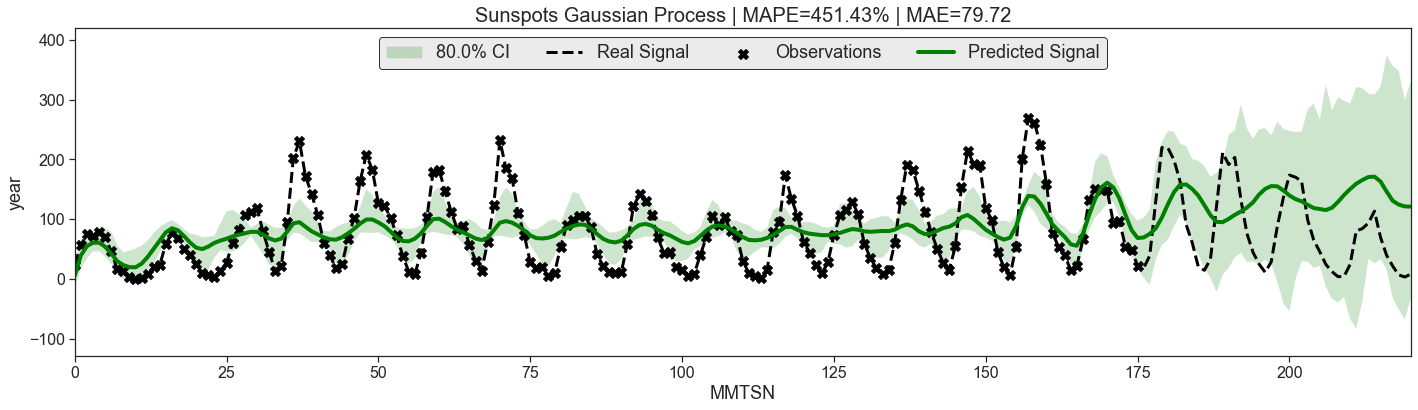

In [102]:
tgp_spp.plot_predict('Sunspots Gaussian Process', 'MMTSN', 'year', nsamples=10, valid_index=valid_index_anual, plot_samples = False, 
)

  0%|                                                                                                         …

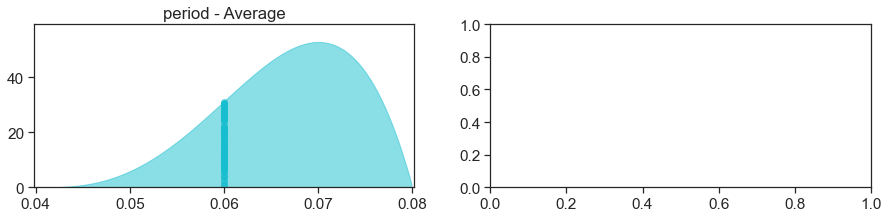

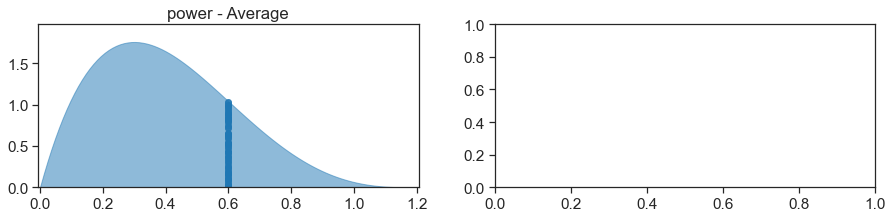

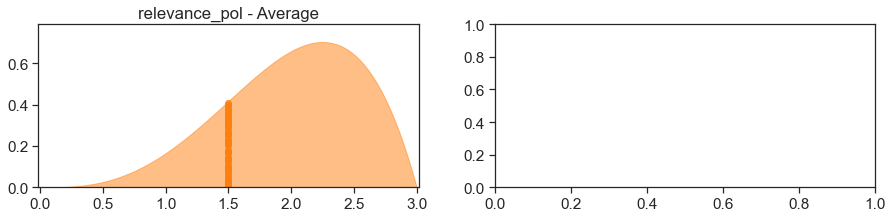

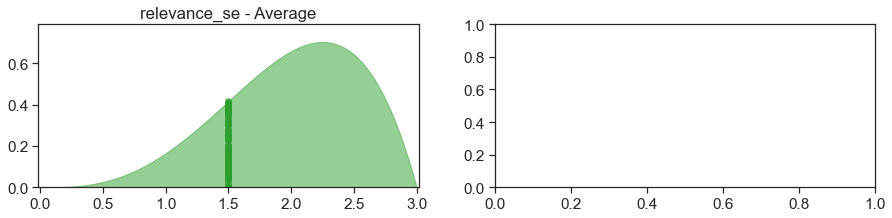

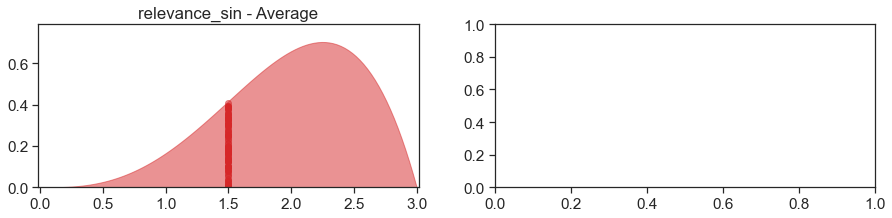

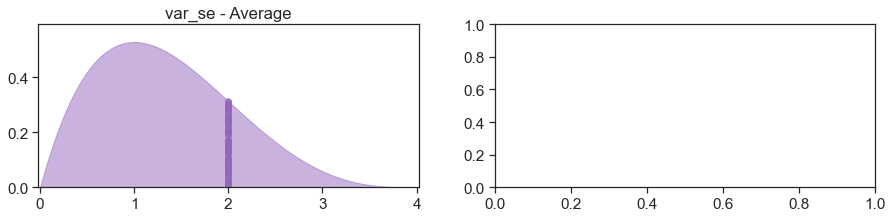

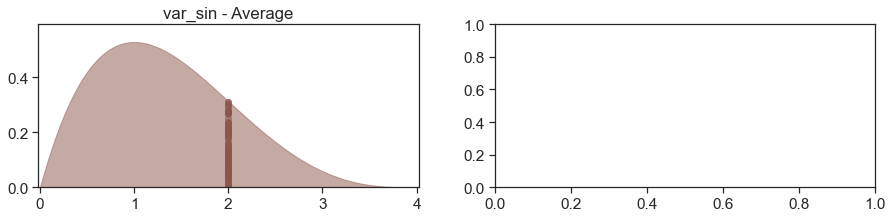

In [103]:
train(tgp_spp)

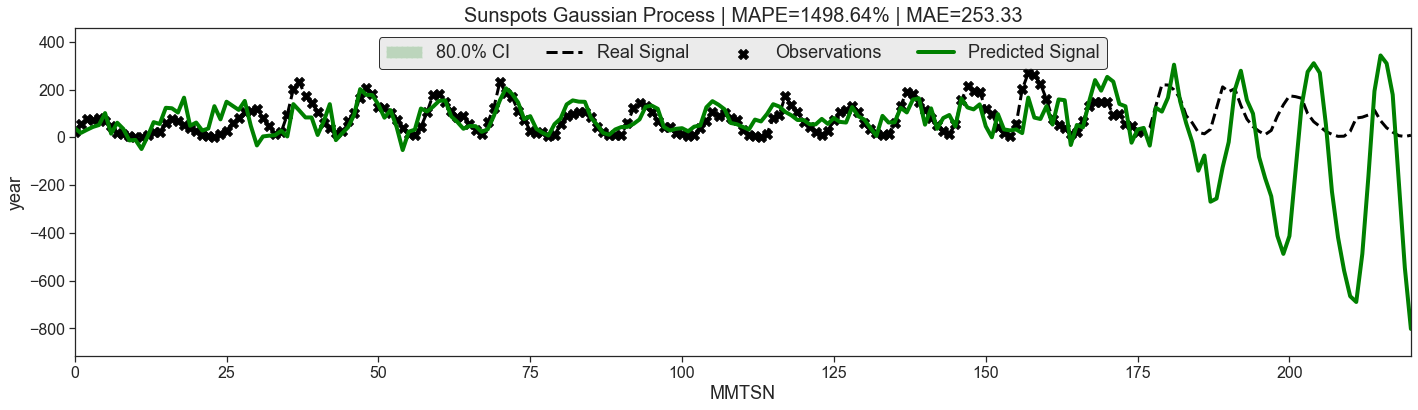

In [104]:
tgp_spp.plot_predict('Sunspots Gaussian Process', 'MMTSN', 'year', nsamples=10, valid_index=valid_index_anual, plot_samples = False, 
)

In [62]:
def model_Rq(df, index_obs, dim = 100): 
    inputs = ['year']
    outputs = ['Monthly Mean Total Sunspot Number']
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs, device='cpu')
    
    var_rq = tg.TgPrior('var_rq', ['Sunspots'], dim=dim, low=0.001, high=1, alpha=2, beta=4)
    relevance = tg.TgPrior('relevance', ['Year'], dim=dim, low=0.001, high=0.05, alpha=2, beta=4) #low = 0.0, high = 2
    freedom = tg.TgPrior('freedom', ['Sunspots'], dim=dim, low=1, high=5, alpha=2, beta=4) #low = 1, high = 5 
    shift = tg.TgPrior('shift', ['Sunspots'], dim=dim, low=-0.01, high=0.01, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Sunspots'], dim=dim, low=0.01, high=1.2, alpha=2, beta=4)
    noise = tg.TgPrior('noise', ['noise'], dim=dim, low=0.001, high=0.5, alpha=2, beta=4)
    
    
    kernel = tg.RQ(var_rq, relevance, freedom)
    cov = tg.CovarianceTransport(kernel, noise=tg.WN(noise))
    marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift) )
    positive = tg.MarginalTransport(tg.Relu())
    
    tgp = tg.TGP([cov, marginal, positive], dt=dt)
    tgp.obs(index_obs)
    return(tgp)

In [63]:
tgp_Rq = model_Rq(S_train, train_index_anual)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
(tgp_Rq).plot_predict('Sunspots Gaussian Process', 'MMTSN', 'year', nsamples=10,
                      valid_index=valid_index_anual, plot_samples = True)

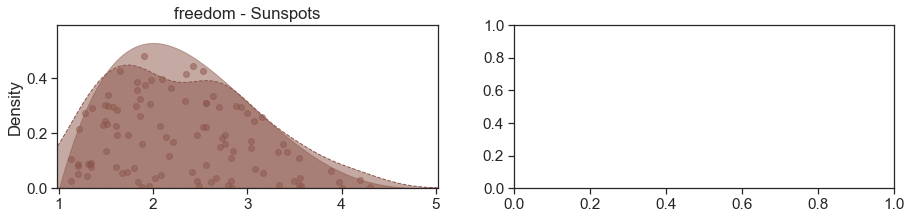

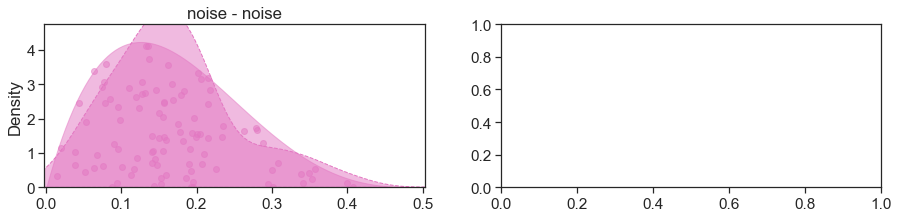

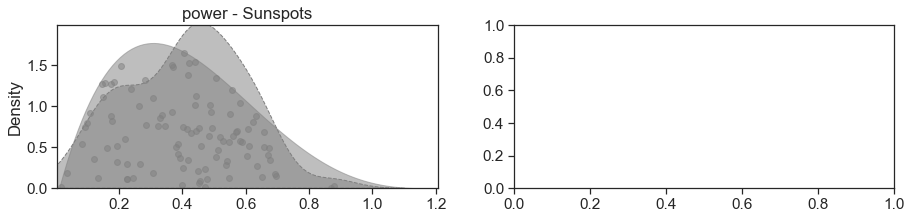

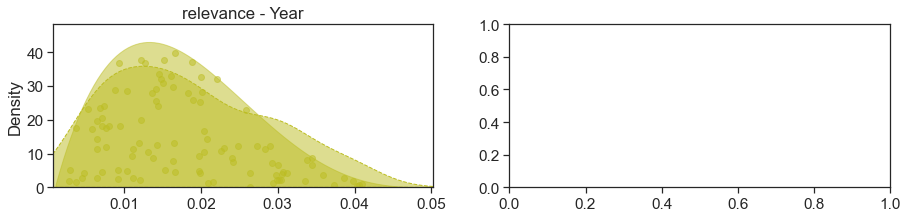

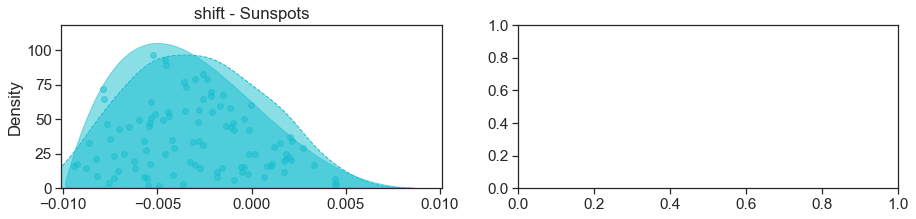

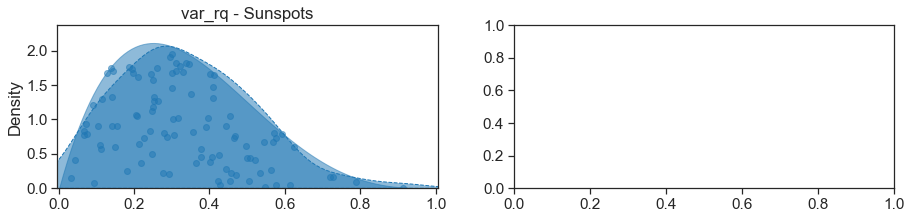

  0%|                                                                                                         …

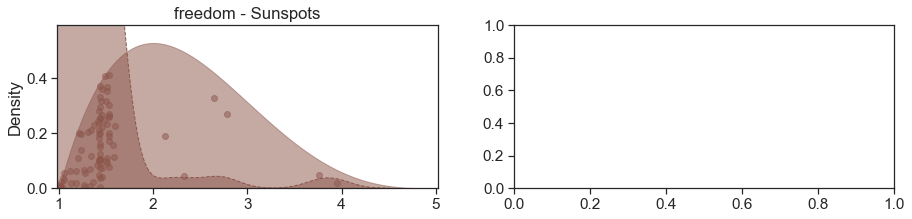

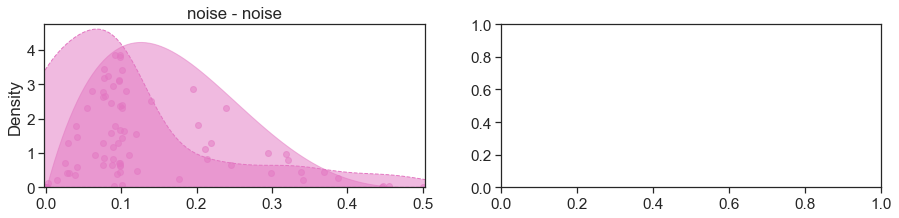

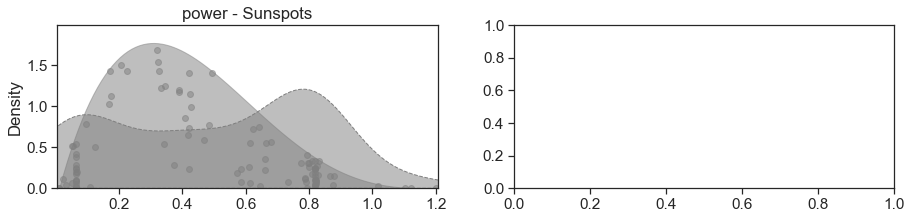

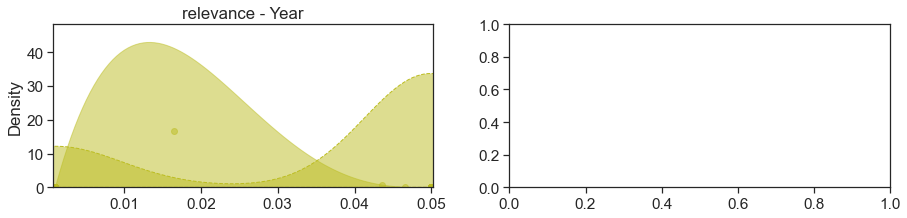

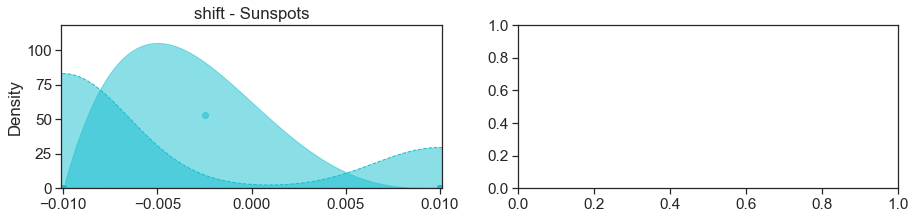

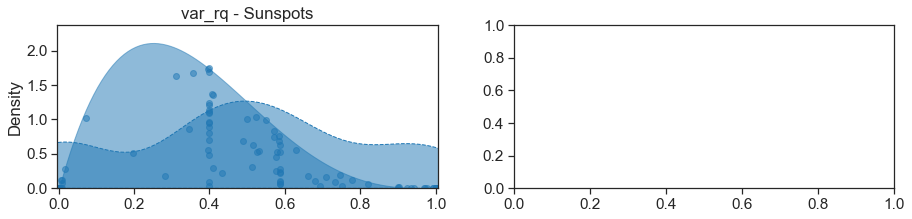

In [56]:
train(tgp_Rq)

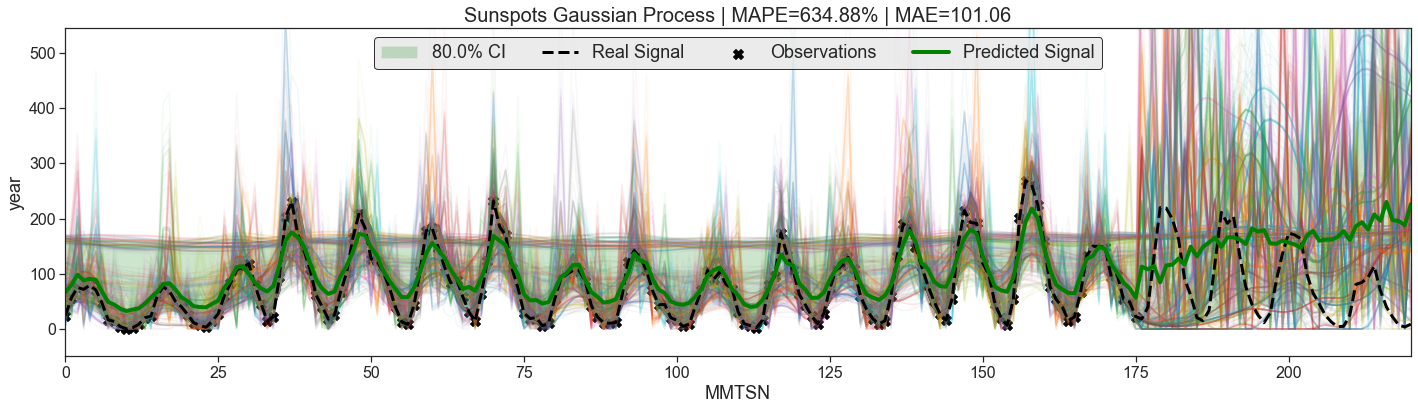

In [57]:
(tgp_Rq).plot_predict('Sunspots Gaussian Process', 'MMTSN', 'year', nsamples=10,
                      valid_index=valid_index_anual, plot_samples = True)
